<a href="https://colab.research.google.com/github/SergeiVKalinin/hello-world/blob/master/MultiTaskGP_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Prepared by Maxim Ziatdinov (July 2023)*

In a multi-output Gaussian Process (GP), we aim to model multiple outputs (tasks, fidelities) that share some inputs. One popular approach is the linear coregionalization model (LCM), in which we assume that each output task is generated as a linear combination of several latent functions, with each latent function having its own task and data kernels. In LCM, each output task is modelled as:

\begin{equation}
y_{d}(\mathbf{x}) = \sum_{q=1}^{Q} u_{q}(\mathbf{x}, d) + \epsilon_{d}(\mathbf{x}),
\end{equation}

where $Q$ is a total number of latent functions, $d$ is a task number, and $\epsilon_{d}(\mathbf{x})$ is a task-specific noise. Each latent function $u_{q}(\mathbf{x}, d)$ follows a GP:

\begin{equation}
u_{q}(\mathbf{x}, d) \sim GP(0, k_{q}^{task}(d, d') k_{q}^{data}(\mathbf{x}, \mathbf{x'})),
\end{equation}

where $k_{q}^{task}(d, d')$ is a task kernel that models the correlation between the tasks, and $k_{q}^{data}(\mathbf{x}, \mathbf{x'})$ is a data kernel that models the correlation of the inputs. Hence, the covariance between any two outputs $y_{d}(\mathbf{x})$ and $y_{d'}(\mathbf{x'})$ is given by

\begin{equation}
\text{cov}(y_{d}(\mathbf{x}), y_{d'}(\mathbf{x'})) = \sum_{q=1}^{Q} k_{q}^{task}(d, d') k_{q}^{data}(\mathbf{x}, \mathbf{x'}).
\end{equation}

This covariance structure provides the ability to capture correlations across the tasks.

Install GPax:

In [ ]:
!pip install git+https://github.com/ziatdinovmax/gpax@multitask

  Cloning https://github.com/ziatdinovmax/gpax (to revision multitask) to /tmp/pip-req-build-mgfdox9v
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/gpax /tmp/pip-req-build-mgfdox9v
  Running command git checkout -b multitask --track origin/multitask
  Switched to a new branch 'multitask'
  Branch 'multitask' set up to track remote branch 'multitask' from 'origin'.
  Resolved https://github.com/ziatdinovmax/gpax to commit a9cab075403a5e0cbdd3e0f0d4904f84a5967622
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 20.0 MB/s eta 0:00:00
  Created wheel for gpax: filename=gpax-0.0.8-py3-none-any.whl size=54932 sha256=0f18231dbc023d10954b7684f67bf9e841a6ea4e848c04fd9c65f6fd74866813
  Stored in directory: /tmp/pip-ephem-wheel-cache-5obn3j2h/wheels/b2/5e/07/48a5c2e2087c4e1096b61b01a01320636a87497e5e883181a9
Successfully built

Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import gpax

gpax.utils.enable_x64()

Let's create toy datasets. The idea is that we have a cheap theoretical simulation that we can perform over the entire parameter space and costly experiments that we can measure only in some parts of that aprameter space. The theory and experiment do not match 100%. We want to use multi-fidelity/task GP to learn the correlation between the theoretical simulations and available experimental observations and use this information to aid predictions in the unmeasured parts of the parameter space.

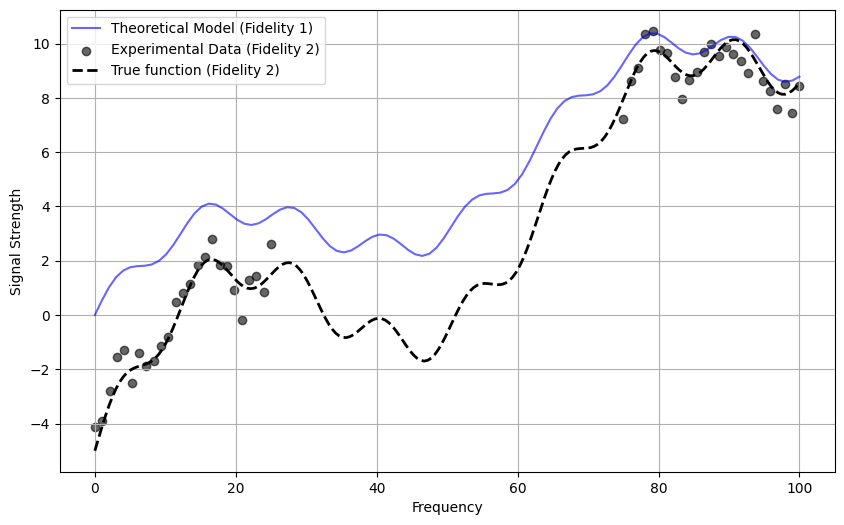

In [ ]:
def theoretical_signal(x):
    # Assume signal strength is some complex function of frequency x
    return 2 * np.sin(x/10) + 0.5 * np.sin(x/2) + 0.1 * x

np.random.seed(0) # for reproducibility

# Fidelity 1 - "theoretical model"
X1 = np.linspace(0, 100, 100)
y1 = theoretical_signal(X1)

# Fidelity 2 - "experimental measurements"
X2 = np.concatenate([np.linspace(0, 25, 25), np.linspace(75, 100, 25)])  # only have data for some frequencies
y2 = 1.5 * theoretical_signal(X2) - 5 + np.random.normal(0, 0.5, X2.shape) + np.sin(X2/15)

# Ground truth for Fidelity 2
X_full_range = np.linspace(0, 100, 200)
y2_true = 1.5 * theoretical_signal(X_full_range) - 5 + np.sin(X_full_range/15)


# Add fidelity indices
X = np.vstack(
    (np.column_stack((X1, np.zeros_like(X1))),  # add indices associated with the fidelity
     np.column_stack((X2, np.ones_like(X2)))) # # add indices associated with the fidelity
)

# We will pass target values to GP as a single array
y = np.concatenate([y1, y2]).squeeze()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.plot(X_full_range, y2_true, 'k--', label='True function (Fidelity 2)', linewidth=2)
plt.xlabel('Frequency')
plt.ylabel('Signal Strength')
plt.legend()
plt.grid(True)
plt.show()


First, let's run a regular GP for the experimental data alone:

In [ ]:
key1, key2 = gpax.utils.get_keys(1)

model = gpax.ExactGP(1, kernel='Matern')
model.fit(key1, X2, y2)

sample: 100%|██████████| 4000/4000 [00:25<00:00, 154.98it/s, 3 steps of size 6.41e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      8.57      1.50      8.43      6.17     10.71   1335.49      1.00
    k_scale     17.94      7.07     16.49      7.78     27.90   1215.62      1.00
      noise      0.29      0.08      0.27      0.17      0.41   1328.46      1.00



Make a prediciton with the trained model:

In [ ]:
# Create a set of test inputs for the task/fidelity 2
X_test2 = X_full_range

# Make a prediction with the trained model
y_mean2, y_sampled2 = model.predict(key2, X_test2, noiseless=True)

Plot results:

Text(0.5, 1.0, 'Vanilla GP')

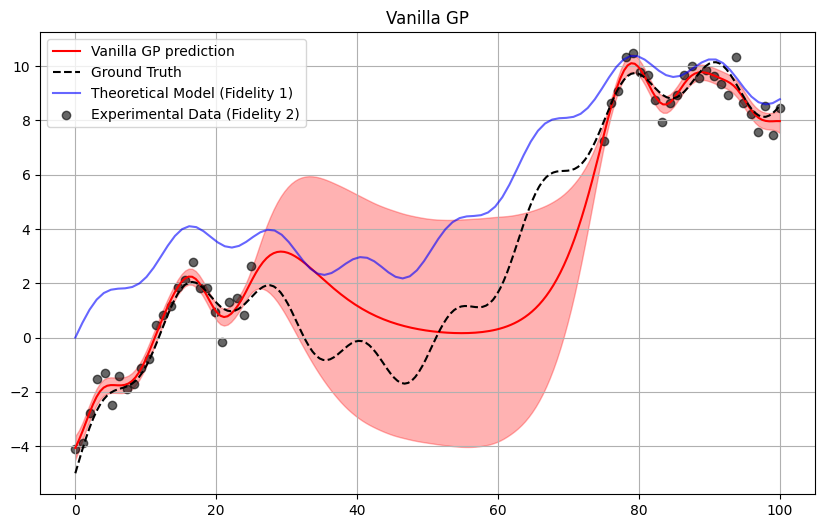

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(X_full_range, y_mean2, c='red', label="Vanilla GP prediction")
plt.fill_between(X_full_range,
                y_mean2 - y_sampled2.squeeze().std(0),
                y_mean2 + y_sampled2.squeeze().std(0),
                alpha=0.3, color='red')
plt.plot(X_full_range, y2_true, 'k--', label='Ground Truth')
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.legend(loc='best')
plt.grid(True)
plt.title("Vanilla GP")

Now let's train a multi-task/fidelity GP model. Start with a single latent function:

In [ ]:
key1, key2 = gpax.utils.get_keys(1)

num_latents = 1

model = gpax.MultiTaskGP(1, data_kernel='Matern', num_latents=num_latents, shared_input_space=False)
model.fit(key1, X, y)

sample: 100%|██████████| 4000/4000 [01:22<00:00, 48.71it/s, 15 steps of size 2.54e-01. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     B[0,0,0]      4.00      0.75      3.91      2.76      5.20   1120.25      1.00
     B[0,1,0]      5.30      1.30      5.09      3.34      7.29   1178.81      1.00
k_length[0,0]     16.96      1.22     16.84     14.75     18.76   1147.92      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   noise[0,0]      0.00      0.00      0.00      0.00      0.00   2018.50      1.00
   noise[0,1]      0.37      0.09      0.35      0.23      0.51   1859.97      1.00
       v[0,0]      1.84      1.26      1.58      0.11      3.54   1629.74      1.00
       v[0,1]      1.85      1.83      1.34      0.06      3.83   1898.80      1.00



Make prediction (for the second task/input only) and plot results:

In [ ]:
# Create a set of inputs for the task/fidelity 2
X_test2 = np.column_stack((X_full_range, np.ones_like(X_full_range)))

# Make a prediction with the trained model
y_mean2, y_sampled2 = model.predict(key2, X_test2, noiseless=True)

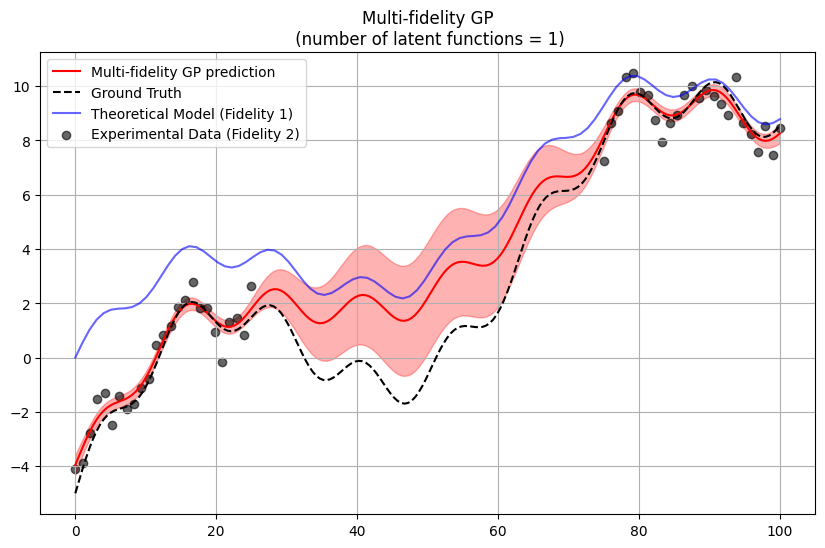

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(X_full_range, y_mean2, c='red',label="Multi-fidelity GP prediction")
plt.fill_between(X_full_range,
                y_mean2 - y_sampled2.squeeze().std(0),
                y_mean2 + y_sampled2.squeeze().std(0),
                alpha=0.3, color='red')
plt.plot(X_full_range, y2_true, 'k--', label='Ground Truth')
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.legend(loc='best')
plt.grid(True)
plt.title("Multi-fidelity GP\n (number of latent functions = {})".format(num_latents));

Not bad. Now let's see if we can improve results by increasing a number of latent functions:

In [ ]:
key1, key2 = gpax.utils.get_keys(1)

num_latents = 2

model = gpax.MultiTaskGP(1, data_kernel='Matern', num_latents=num_latents, shared_input_space=False)
model.fit(key1, X, y)

sample: 100%|██████████| 4000/4000 [05:15<00:00, 12.69it/s, 31 steps of size 5.38e-02. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     B[0,0,0]      0.09      3.40      0.36     -4.71      5.19    151.19      1.01
     B[0,1,0]      0.20      5.05      0.28     -7.38      7.85    148.16      1.01
     B[1,0,0]      0.30      3.49      0.91     -4.83      5.21    143.13      1.05
     B[1,1,0]      0.57      5.23      0.84     -7.55      8.06    139.45      1.04
k_length[0,0]     28.24     19.82     19.10      9.94     52.46    389.71      1.01
k_length[1,0]     26.73     18.65     18.15     10.55     50.25    368.06      1.01
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   k_scale[1]      1.00      0.00      1.00      1.00      1.00       nan       nan
   noise[0,0]      0.00      0.00      0.00      0.00      0.00   1610.93      1.00
   noise[0,1]      0.19      0.09      0.18      0.05      0.33   1777.56      1.00
   noise[1,0]      0.00      0.00      0.00      0.00      0.00   1703.09  

Make a prediction and plot results:

In [ ]:
# Create a set of inputs for the task/fidelity 2
X_test2 = np.column_stack((X_full_range, np.ones_like(X_full_range)))

# Make a prediction with the trained model
y_mean2, y_sampled2 = model.predict(key2, X_test2, noiseless=True)

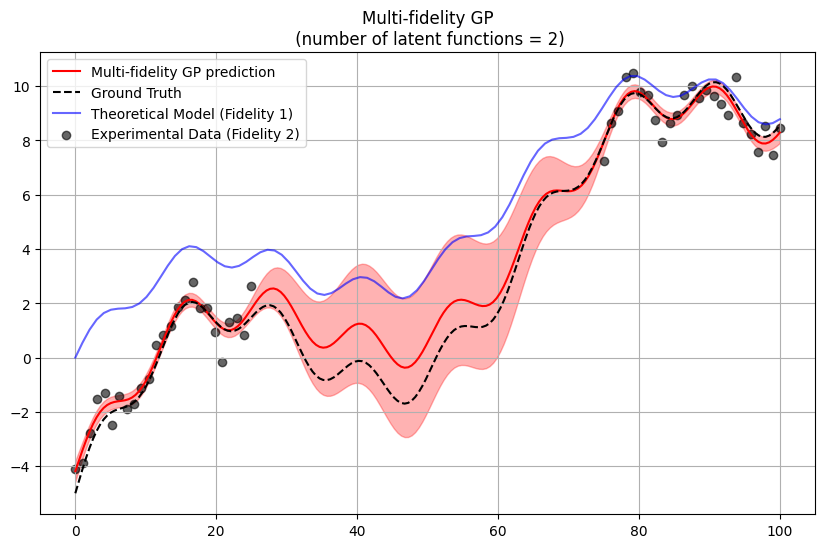

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(X_test2[:,0], y_mean2, c='red', label="Multi-fidelity GP prediction")
plt.fill_between(X_test2[:,0],
                y_mean2 - y_sampled2.squeeze().std(0),
                y_mean2 + y_sampled2.squeeze().std(0),
                alpha=0.3, color='red')
plt.plot(X_full_range, y2_true, 'k--', label='Ground Truth')
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.legend(loc='best')
plt.grid(True)
plt.title("Multi-fidelity GP\n (number of latent functions = {})".format(num_latents));

The task kernel is computed as

$$ k_{task}[i, j] = BB^T[i, j] + v[i] \delta_{ij} $$

where $BB^T$ is the matrix product of B with its transpose, $v[i]$ is the variance of task i, and $\delta_{ij}$ is the Kronecker delta which is 1 if $i == j$ and 0 otherwise.

The default priors on the B matrices of the task kernel are $Normal(0, 10)$. This is obviously not very informative and may lead to long convergence times, especially for high-diemnsional problems with many tasks. We can narrow them down by using results of a multi-task GP with a single latent function (which is cheaper to compute):

In [ ]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp

def task_kernel_prior():
        B_dist = dist.Normal(
                3*jnp.ones(shape=(num_latents, 2, 1)),  # loc
                2*jnp.ones(shape=(num_latents, 2, 1)) # var
        )
        v_dist = dist.LogNormal(
                jnp.zeros(shape=(num_latents, 2)),  # loc
                jnp.ones(shape=(num_latents, 2)) # var
        )
        with numpyro.plate("latent_plate_task", num_latents):  # accounts for the conditional independncy of latent functions
            B = numpyro.sample("B", B_dist.to_event(2))
            v = numpyro.sample("v", v_dist.to_event(1))
        return {"B": B, "v": v}

Let's run multi-task GP with these custom defined priors:

In [ ]:
key1, key2 = gpax.utils.get_keys(1)

model = gpax.MultiTaskGP(1, data_kernel='Matern', num_latents=num_latents,
                         shared_input_space=False, task_kernel_prior=task_kernel_prior)
model.fit(key1, X, y)

sample: 100%|██████████| 4000/4000 [04:05<00:00, 16.33it/s, 63 steps of size 7.63e-02. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     B[0,0,0]      2.94      1.04      2.96      1.25      4.57   1129.82      1.00
     B[0,1,0]      3.84      1.56      3.94      1.49      6.68    270.97      1.00
     B[1,0,0]      3.03      1.05      3.04      1.41      4.70    985.98      1.00
     B[1,1,0]      3.70      1.54      3.75      1.10      6.12    370.38      1.00
k_length[0,0]     23.92     17.60     16.20      9.92     44.25    262.09      1.00
k_length[1,0]     25.93     16.84     19.05     10.31     46.75    277.42      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   k_scale[1]      1.00      0.00      1.00      1.00      1.00       nan       nan
   noise[0,0]      0.00      0.00      0.00      0.00      0.00   1772.53      1.00
   noise[0,1]      0.19      0.09      0.18      0.05      0.33   1505.20      1.00
   noise[1,0]      0.00      0.00      0.00      0.00      0.00   1765.68  

Note that it took less time to converge.

In [ ]:
# Create a set of inputs for the task/fidelity 2
X_test2 = np.column_stack((X_full_range, np.ones_like(X_full_range)))

# Make a prediction with the trained model
y_mean2, y_sampled2 = model.predict(key2, X_test2, noiseless=True)

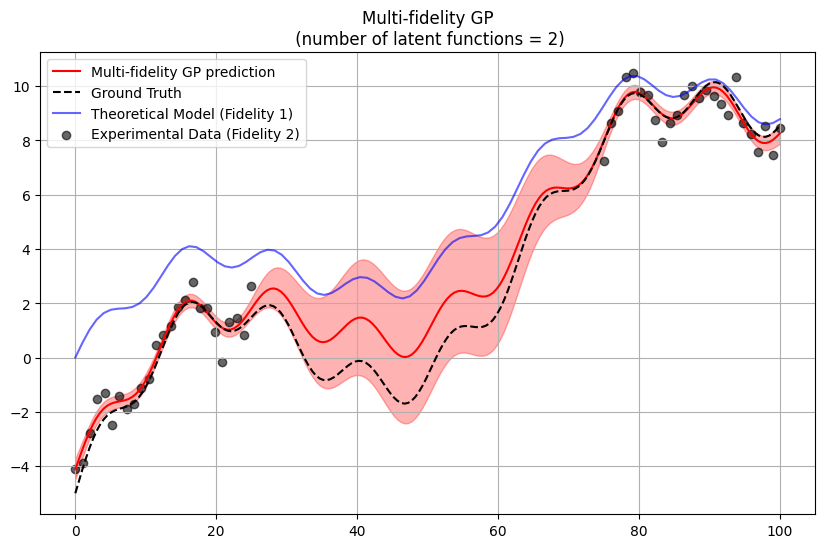

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(X_test2[:,0], y_mean2, c='red', label="Multi-fidelity GP prediction")
plt.fill_between(X_test2[:,0],
                y_mean2 - y_sampled2.squeeze().std(0),
                y_mean2 + y_sampled2.squeeze().std(0),
                alpha=0.3, color='red')
plt.plot(X_full_range, y2_true, 'k--', label='Ground Truth')
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.legend(loc='best')
plt.grid(True)
plt.title("Multi-fidelity GP\n (number of latent functions = {})".format(num_latents));

We can also visualize posterior samples for the B matrices:

Latent 1


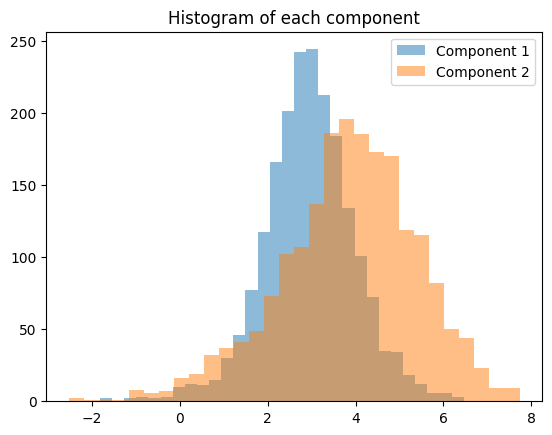

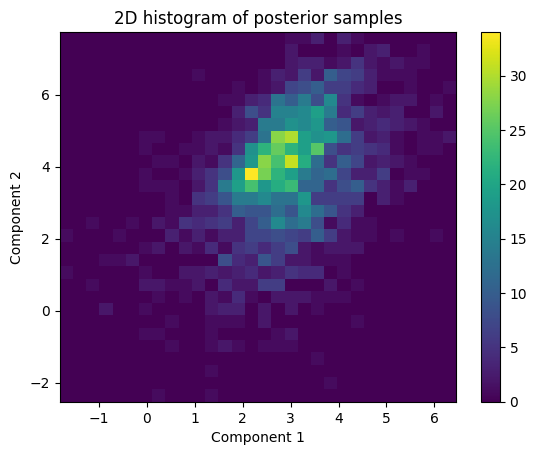

Latent 2


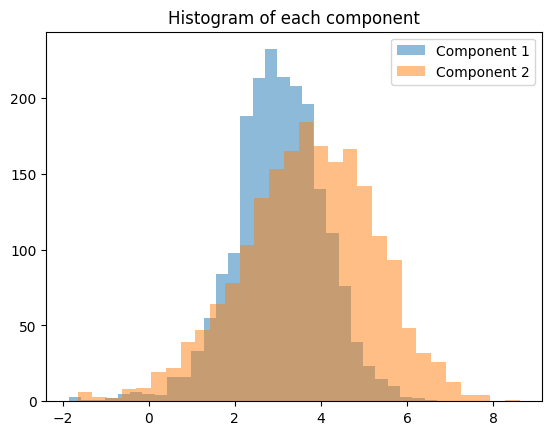

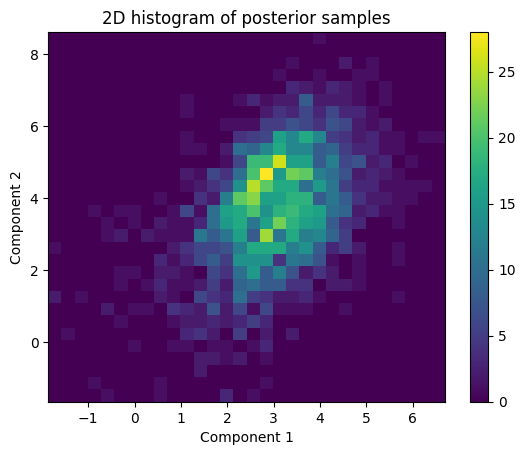

In [ ]:
samples_all = model.get_samples()

for i in range(num_latents):

    print("Latent {}".format(i+1))
    samples = samples_all["B"][:, i].squeeze()

    # Histograms
    plt.figure()
    plt.hist(samples[:, 0], bins=30, alpha=0.5, label='Component 1')
    plt.hist(samples[:, 1], bins=30, alpha=0.5, label='Component 2')
    plt.legend()
    plt.title('Histogram of each component')
    plt.show()

    # 2D histogram
    plt.figure()
    plt.hist2d(samples[:, 0], samples[:, 1], bins=30)
    plt.colorbar()
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D histogram of posterior samples')
    plt.show()

Finally let's see what happens if we fix the elements of the B matrices. We can do this using ```numpyro.deterministic```

In [ ]:
def task_kernel_prior():
    B = numpyro.deterministic("B", 0.5*jnp.ones(shape=(num_latents, 2)))
    v_dist = dist.LogNormal(
            jnp.zeros(shape=(num_latents, 2)),  # loc
            jnp.ones(shape=(num_latents, 2)) # var
    )
    with numpyro.plate("latent_plate_task", num_latents):
        v = numpyro.sample("v", v_dist.to_event(1))
    return {"B": B, "v": v}

In [ ]:
key1, key2 = gpax.utils.get_keys(1)

model = gpax.MultiTaskGP(1, data_kernel='Matern', num_latents=num_latents,
                         shared_input_space=False, task_kernel_prior=task_kernel_prior)
model.fit(key1, X, y)

sample: 100%|██████████| 4000/4000 [02:43<00:00, 24.50it/s, 31 steps of size 9.58e-02. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
       B[0,0]      0.50      0.00      0.50      0.50      0.50       nan       nan
       B[0,1]      0.50      0.00      0.50      0.50      0.50       nan       nan
       B[1,0]      0.50      0.00      0.50      0.50      0.50       nan       nan
       B[1,1]      0.50      0.00      0.50      0.50      0.50       nan       nan
k_length[0,0]     16.58      9.70     13.65      7.19     29.52    109.02      1.00
k_length[1,0]     17.40      9.80     15.00      7.03     30.57    120.63      1.01
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   k_scale[1]      1.00      0.00      1.00      1.00      1.00       nan       nan
   noise[0,0]      0.00      0.00      0.00      0.00      0.00   1209.71      1.00
   noise[0,1]      0.23      0.12      0.21      0.04      0.39   1234.00      1.00
   noise[1,0]      0.00      0.00      0.00      0.00      0.00   1170.01  

In [ ]:
# Create a set of inputs for the task/fidelity 2
X_test2 = np.column_stack((X_full_range, np.ones_like(X_full_range)))

# Make a prediction with the trained model
y_mean2, y_sampled2 = model.predict(key2, X_test2, noiseless=True)

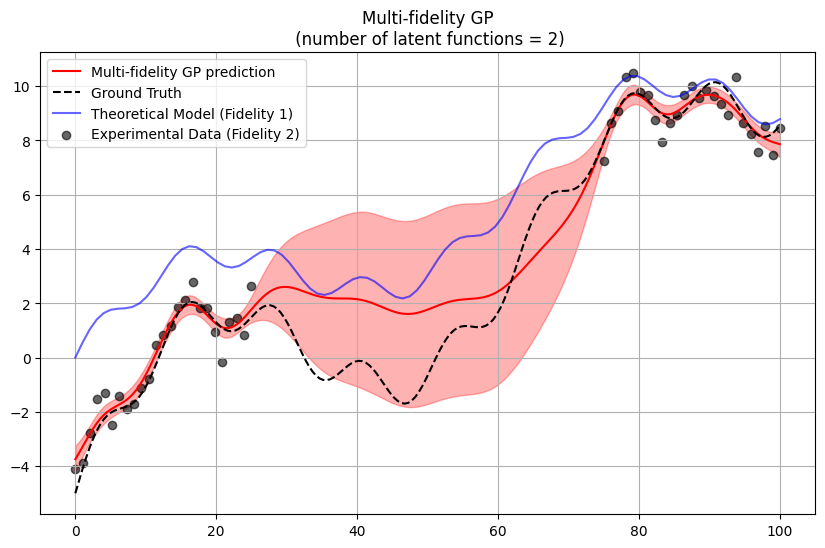

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(X_test2[:,0], y_mean2, c='red', label="Multi-fidelity GP prediction")
plt.fill_between(X_test2[:,0],
                y_mean2 - y_sampled2.squeeze().std(0),
                y_mean2 + y_sampled2.squeeze().std(0),
                alpha=0.3, color='red')
plt.plot(X_full_range, y2_true, 'k--', label='Ground Truth')
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.legend(loc='best')
plt.grid(True)
plt.title("Multi-fidelity GP\n (number of latent functions = {})".format(num_latents));